### BotArtist Dataset

**Hard facts:**
- Collection period: 2022 – early 2023
- Domain: Russo-Ukrainian war (Twitter/X)
- Size: ~10.9M user profiles
- Labels: *bot* vs *human* (machine-predicted, not human verified)
- Features: activity metrics (statuses, followers, following), normalized ratios (per age), profile features (name/description entropy, digit %), metadata (verified, protected, profile image)
- Keywords/hashtags used for collection: `#Ukraine`, `#UkraineWar`, `#StopRussia`, `#StandWithUkraine`, `#Russia`, `#Putin`, `#Zelenskyy`, as well as terms like *Ukraine war*, *Russia invasion*, *Donbas*, *Kyiv*, *Moscow*, *NATO*
- Domains included: news and war-related sources such as `rt.com`, `t.me` (Telegram), `bbc.com/ukraine`, `pravda.com.ua`

**Description:**
The BotArtist dataset was created to study bot activity around the Russo-Ukrainian war. Accounts were collected via the Twitter API v2 using war-related keywords, hashtags, and domains. Labels were generated using the BotArtist classifier, trained on prior bot detection datasets (e.g., Botometer, TwiBot). While very large and feature-rich, its labels rely on machine predictions and should be treated as weak supervision rather than ground truth.

**Source:** [Zenodo](https://zenodo.org/records/11203900), [ArXiv](https://arxiv.org/abs/2306.00037)


## Data Loading

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [30]:
df = pd.read_csv("data/1_BotArtist/russo-ukrainian-war-10M-profiles.csv")

In [31]:
original = df.copy()
#df = original

In [32]:
print("Shape of dataset:", df.shape)
df.head(20)


Shape of dataset: (10929533, 52)


,age,description_urls,description_mentions,description_hashtags,screen_name_sim,statuses,statuses_by_age,following,following_by_age,followers,...,name_entropy,has_location,profile_url,total_urls,foll_friends,verified,protected,uid,label,proba
0,786.0,0,0,0,0.200000,1215,1.545802,258,0.328244,80,...,2.271869,1,1,1,0.310078,0,0,uidb46b767fa5e2d342baaf2fc457a8740e3822837cd22...,human,68
1,4722.0,0,0,0,0.333333,3332,0.705633,49771,10.540237,128211,...,1.609438,0,0,0,2.576018,0,0,uidc43ed59435d39c26a0a3e972241710175492d68024e...,human,66
2,3410.0,0,0,0,0.411765,178614,52.379472,95,0.027859,1642,...,2.441015,1,0,0,17.284211,0,0,uida3eabc8386c783711bca4076378810ab5396082a6e0...,human,99
3,4266.0,2,0,0,0.857143,207601,48.664088,8,0.001875,3911749,...,2.302585,1,1,3,488968.625000,1,0,uidde3a6fd227120315235df6807eb63b035159a98b771...,human,99
4,2083.0,0,0,0,0.692308,1271,0.610178,138,0.066251,30,...,2.351673,0,0,0,0.217391,0,0,uid9dcc848e0b07d43d9df616f4969c72d84d863c34e88...,bot,54
5,5224.0,0,3,0,0.416667,27539,5.271631,1394,0.266845,2006632,...,2.484367,1,1,1,1439.477762,1,0,uid2991f96db7414c07aa693416ab33b61e42e80b155ff...,human,99
6,870.0,0,0,0,0.307692,2331,2.679310,325,0.373563,152,...,2.197225,1,0,0,0.467692,0,0,uida01bd6e0b465dd11cee30a0f557de3ef19d2a89eb8c...,human,95
7,1239.0,1,2,0,1.000000,33541,27.071025,5,0.004036,2514015,...,2.025326,1,1,2,502803.000000,1,0,uid12f2f7b396da805b7886496822ea8c59ae54399bf65...,human,99
8,1328.0,0,0,0,0.000000,10589,7.973645,318,0.239458,193,...,2.523211,1,1,1,0.606918,0,0,uidce1770603129fa04acead7cd418ef332f0eda9c4976...,human,93
9,1127.0,1,0,1,0.266667,1728,1.533274,44,0.039042,15908,...,2.532591,1,1,2,361.545455,0,0,uid8d373f6484a5f7c4d2c3b4b300f5cb2dbd5aab4108e...,human,91


## EDA

In [33]:
# Basic info
df.info()

# Check missing values
missing = df.isnull().sum().sort_values(ascending=False)
print("\nMissing values per column:")
print(missing[missing > 0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10929533 entries, 0 to 10929532
Data columns (total 52 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   age                     float64
 1   description_urls        int64  
 2   description_mentions    int64  
 3   description_hashtags    int64  
 4   screen_name_sim         float64
 5   statuses                int64  
 6   statuses_by_age         float64
 7   following               int64  
 8   following_by_age        float64
 9   followers               int64  
 10  followers_by_age        float64
 11  listed                  int64  
 12  listed_by_age           float64
 13  profile_image           int64  
 14  description_upper_len   int64  
 15  description_lower_len   int64  
 16  description_digit_len   int64  
 17  description_spec_len    int64  
 18  description_upper_pcnt  float64
 19  description_lower_pcnt  float64
 20  description_digit_pcnt  float64
 21  description_spec_pcnt   float

In [34]:

# Summary statistics for numerical features
print("\nSummary statistics:")
print(df.describe().T)




Summary statistics:
                             count          mean            std   min  \
age                     10929533.0  1.985266e+03    1647.581753   0.0   
description_urls        10929533.0  4.246815e-02       0.247713   0.0   
description_mentions    10929533.0  8.819407e-03       0.155272   0.0   
description_hashtags    10929533.0  2.414037e-02       0.339279   0.0   
screen_name_sim         10929533.0  4.476854e-01       0.300895   0.0   
statuses                10929533.0  1.411933e+04   44191.322833   0.0   
statuses_by_age         10929533.0  1.172147e+01      43.407355   0.0   
following               10929533.0  7.760640e+02    3361.368815   0.0   
following_by_age        10929533.0  1.780805e+00      11.045350   0.0   
followers               10929533.0  3.286531e+03  182082.271002   0.0   
followers_by_age        10929533.0  2.108980e+00     800.942224   0.0   
listed                  10929533.0  1.627956e+01     389.508591   0.0   
listed_by_age           109295

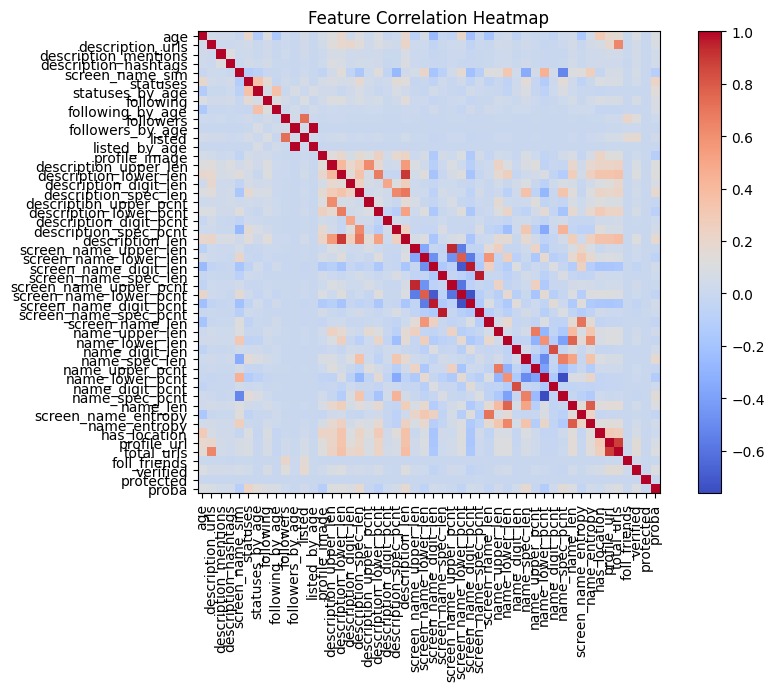

In [35]:
# Example correlations
num_cols = df.select_dtypes(include="number").columns
corr = df[num_cols].corr()
plt.figure(figsize=(10, 6))
plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Feature Correlation Heatmap")
plt.show()

In [36]:
print(corr)

                             age  description_urls  description_mentions  \
age                     1.000000          0.043063              0.032937   
description_urls        0.043063          1.000000              0.013967   
description_mentions    0.032937          0.013967              1.000000   
description_hashtags    0.022752          0.009903              0.108164   
screen_name_sim        -0.010071          0.026211              0.016573   
statuses                0.199556          0.038894              0.028263   
statuses_by_age        -0.127959          0.004152              0.007205   
following               0.095239          0.034032              0.030657   
following_by_age       -0.151648         -0.001025              0.000123   
followers               0.021279          0.013811              0.019015   
followers_by_age       -0.000682          0.001321              0.001110   
listed                  0.053534          0.034126              0.032187   
listed_by_ag

Class counts:
 label
human    6707355
bot      4222178
Name: count, dtype: int64

Class percentages:
 label
human    61.37
bot      38.63
Name: proportion, dtype: float64


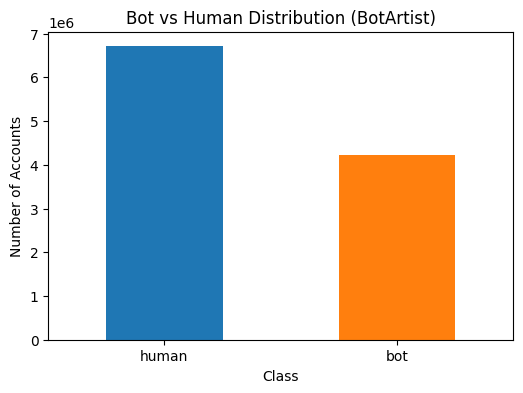

In [37]:
class_counts = df["label"].value_counts()
class_perc = df["label"].value_counts(normalize=True) * 100

print("Class counts:\n", class_counts)
print("\nClass percentages:\n", class_perc.round(2))

# Plot
plt.figure(figsize=(6,4))
class_counts.plot(kind="bar", color=["#1f77b4", "#ff7f0e"])
plt.title("Bot vs Human Distribution (BotArtist)")
plt.xlabel("Class")
plt.ylabel("Number of Accounts")
plt.xticks(rotation=0)
plt.show()

In [ ]:
# max 9 plots
features_to_plot = [
    ("followers", "Followers Count"),
    ("following", "Following Count"),
    ("foll_friends", "Follower/Following Ratio"),
    ("statuses", "Statuses (Posts)"),
    ("statuses_by_age", "Posts per Day Online"),
    ("followers_by_age", "Followers per Day Online"),
    ("following_by_age", "Following per Day Online"),
    ("age", "Age of Accounts (in days)")
]

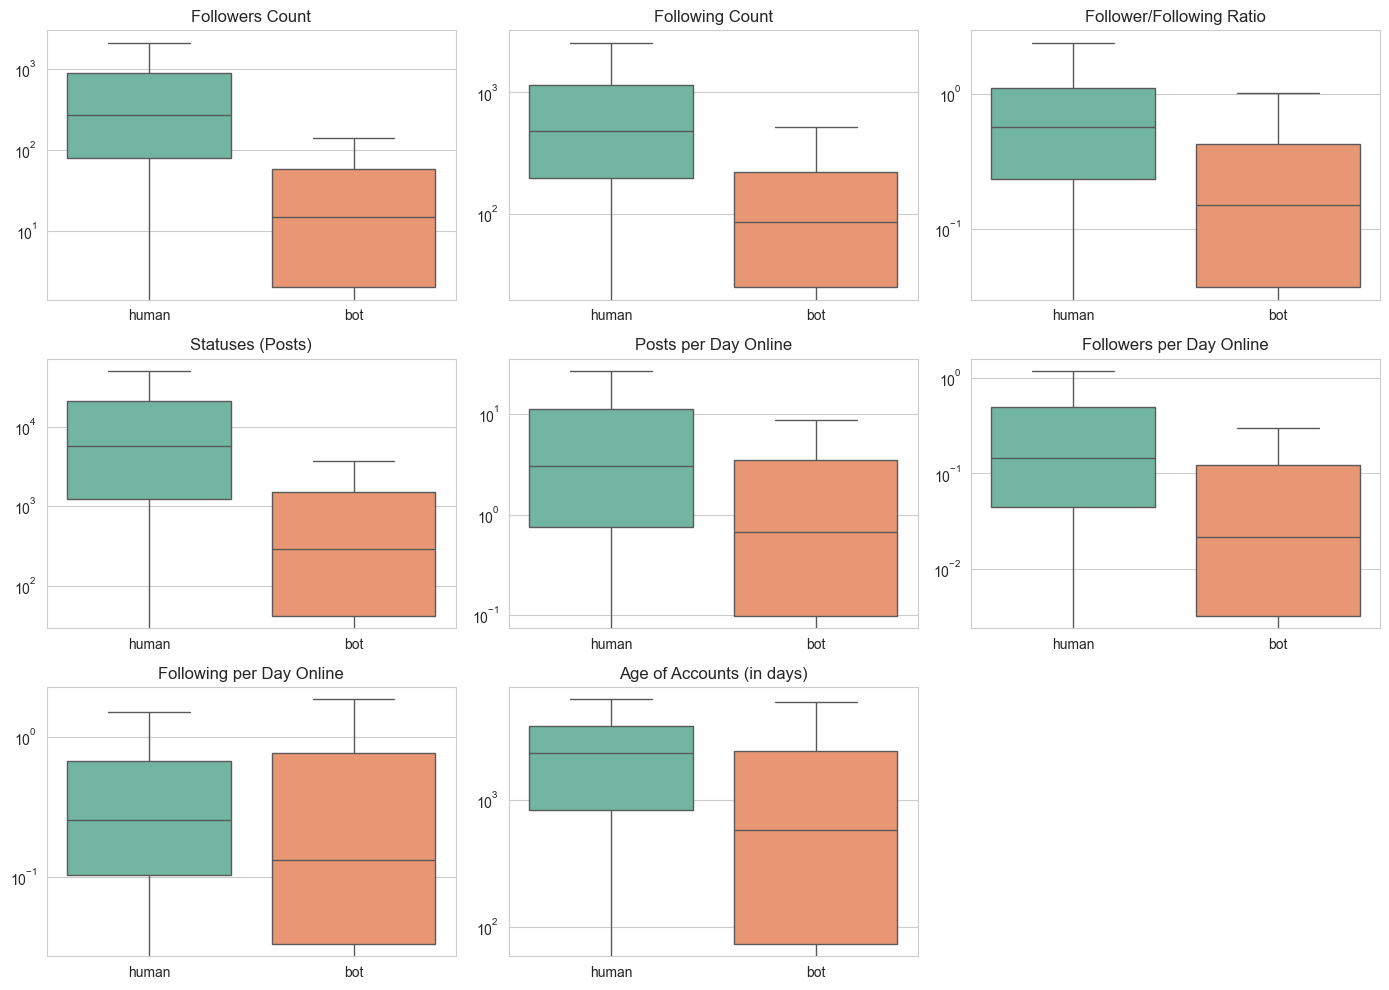

In [39]:
# Boxplots

plt.figure(figsize=(14, 10))
for i, (col, label) in enumerate(features_to_plot, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(
    data=df,
    x="label",
    y=col,
    hue="label",
    showfliers=False,
    palette="Set2",
    legend=False
    )
    plt.yscale("log")
    plt.title(label)
    plt.xlabel("")
    plt.ylabel("")
plt.tight_layout()
plt.show()

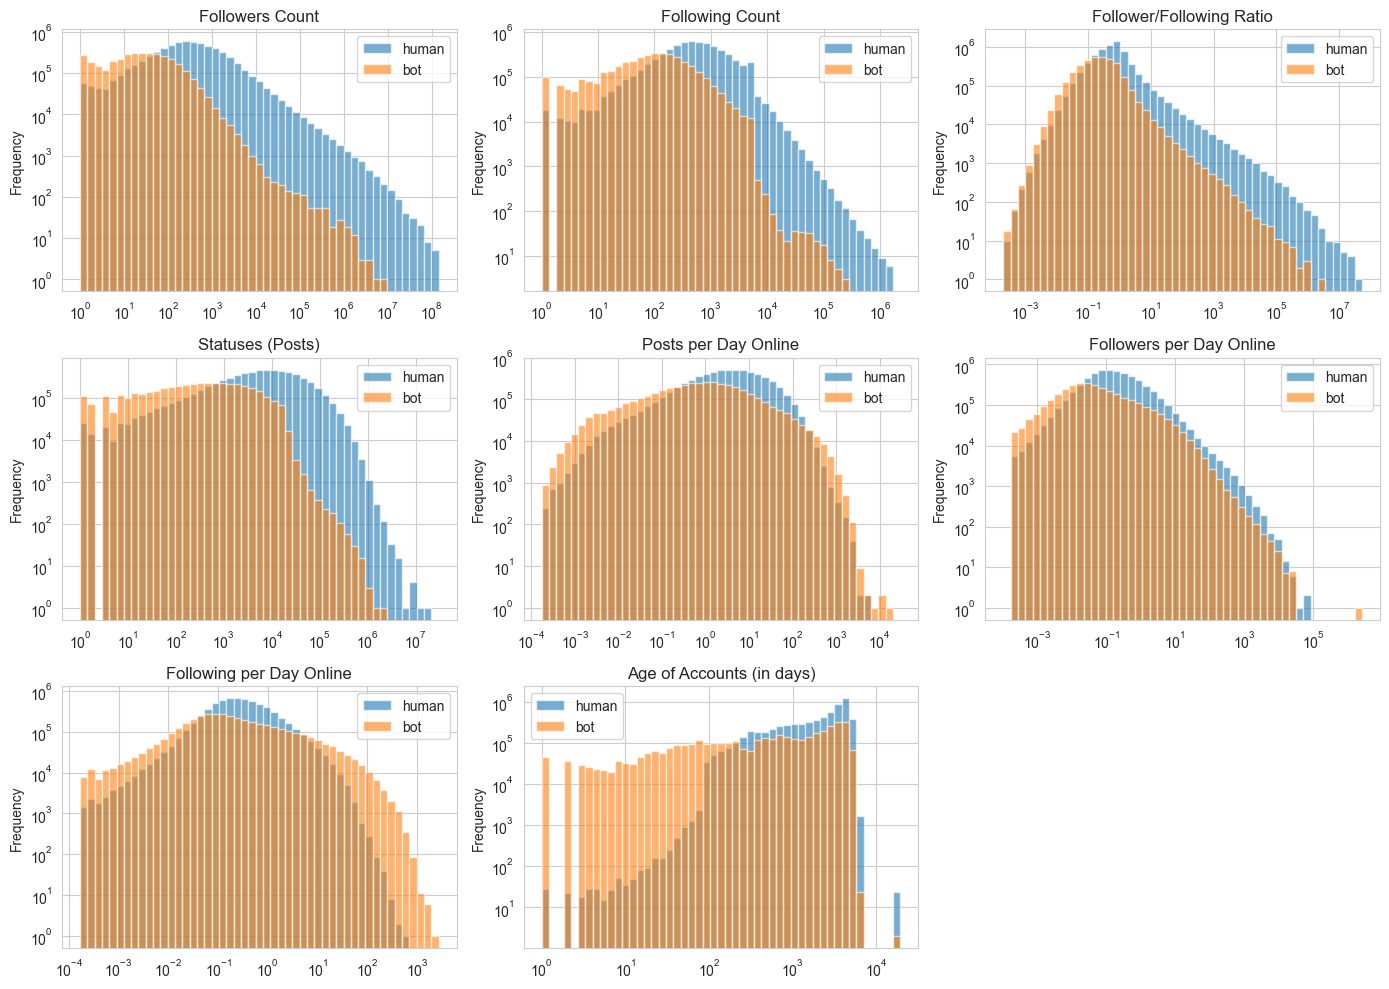

In [45]:
plt.figure(figsize=(14, 10))
for i, (col, label) in enumerate(features_to_plot, 1):
    plt.subplot(3, 3, i)

    # remove non-positive values for log binning
    values = df[col][df[col] > 0]

    # log-spaced bins
    bins = np.logspace(np.log10(values.min()), np.log10(values.max()), 50)

    # plot histogram split by label
    for lbl, color in zip(df["label"].unique(), ["#1f77b4", "#ff7f0e"]):
        subset = df[df["label"] == lbl][col]
        plt.hist(
            subset[subset > 0],
            bins=bins,
            alpha=0.6,
            label=lbl,
            color=color
        )

    plt.xscale("log")
    plt.yscale("log")
    plt.title(label)
    plt.xlabel("")
    plt.ylabel("Frequency")
    plt.legend()

plt.tight_layout()
plt.show()

In [49]:
# Step 1: identify categorical columns (object, bool, category)
cat_cols = df.select_dtypes(include=["object", "bool", "category"]).columns.tolist()
print("Categorical columns found:", cat_cols)

# Step 2: Pick the most relevant categorical features
interesting_cats = [col for col in cat_cols if col in ["verified", "protected", "has_profile_image"]]

# Step 3: Analyze them
for col in interesting_cats:
    print(f"\n--- {col} ---")
    counts = df.groupby(["label", col]).size().unstack(fill_value=0)
    perc = counts.div(counts.sum(axis=1), axis=0) * 100

    display(counts)  # absolute counts
    display(perc.round(2))  # percentage per label

    # Plot
    counts.plot(
        kind="bar",
        stacked=True,
        figsize=(6,4),
        title=f"{col} distribution by label"
    )
    plt.ylabel("Number of accounts")
    plt.show()


Categorical columns found: ['uid', 'label']


## Preprocessing